In [130]:
import numpy as np
import pandas as pd

import torch

In [272]:
import seaborn as sns

import matplotlib.pyplot as plt

In [3]:
import sys

In [50]:
from copy import deepcopy

In [6]:
sys.path.append('../')
sys.path.append('../../')

In [43]:
from dltranz.util import init_logger, get_conf
from dltranz.models import model_by_type
from retail_embeddings_projects.embedding_tools.inference_tools import score_part_of_data

In [31]:
from sber_target import read_consumer_data, create_ds, run_experiment

In [81]:
train_target = pd.read_csv('/data/kireev-ia/data_open_ds/age-prediction-nti-sbebank-2019/data/train_target.csv')
train_target.head(5)

,client_id,bins
0,24662,2
1,1046,0
2,34089,2
3,34848,1
4,47076,3


In [22]:
init_logger(__name__)
init_logger('sber_target')
init_logger('dltranz')
init_logger('retail_embeddings_projects.embedding_tools')

In [34]:
args = [
    'data_path=""',
    'output.path="pca_vectors"',
    '--conf',
    '../conf/sber_target_dataset.hocon',
    '../conf/sber_target_params_train.json',
]
conf = get_conf(args)

2019-12-25 11:29:49,905 INFO    dltranz.util           : args: Namespace(conf=['../conf/sber_target_dataset.hocon', '../conf/sber_target_params_train.json']), overrides: ['data_path=""', 'output.path="pca_vectors"']
2019-12-25 11:29:49,905 INFO    dltranz.util           : args: Namespace(conf=['../conf/sber_target_dataset.hocon', '../conf/sber_target_params_train.json']), overrides: ['data_path=""', 'output.path="pca_vectors"']
2019-12-25 11:29:49,912 INFO    dltranz.util           : Load config from "../conf/sber_target_dataset.hocon"
2019-12-25 11:29:49,912 INFO    dltranz.util           : Load config from "../conf/sber_target_dataset.hocon"
2019-12-25 11:29:49,933 INFO    dltranz.util           : Load config from "../conf/sber_target_params_train.json"
2019-12-25 11:29:49,933 INFO    dltranz.util           : Load config from "../conf/sber_target_params_train.json"


In [24]:
model_f = model_by_type(conf['params.model_type'])

In [25]:
train_data, valid_data = read_consumer_data(conf)

2019-12-25 11:18:15,949 INFO    sber_target            : Data loading...
2019-12-25 11:18:17,445 INFO    sber_target            : Loaded train: 18000, valid: 12000


# Train model

In [32]:
train_ds, valid_ds = create_ds(train_data, valid_data, conf)
model, result = run_experiment(train_ds, valid_ds, conf['params'], model_f)


Epoch: 1,  accuracy: 0.526



Epoch: 2,  accuracy: 0.536



Epoch: 3,  accuracy: 0.568



Epoch: 4,  accuracy: 0.552



Epoch: 5,  accuracy: 0.563



Epoch: 6,  accuracy: 0.567



Epoch: 7,  accuracy: 0.571



Epoch: 8,  accuracy: 0.563



Epoch: 9,  accuracy: 0.580



Epoch: 10,  accuracy: 0.587



Epoch: 11,  accuracy: 0.590



Epoch: 12,  accuracy: 0.597



Epoch: 13,  accuracy: 0.602



Epoch: 14,  accuracy: 0.599



Epoch: 15,  accuracy: 0.595



Epoch: 16,  accuracy: 0.607



Epoch: 17,  accuracy: 0.610



Epoch: 18,  accuracy: 0.609



Epoch: 19,  accuracy: 0.611



Epoch: 20,  accuracy: 0.616



Epoch: 21,  accuracy: 0.616



Epoch: 22,  accuracy: 0.617



Epoch: 23,  accuracy: 0.618



Epoch: 24,  accuracy: 0.617



Epoch: 25,  accuracy: 0.617



Epoch: 26,  accuracy: 0.619



Epoch: 27,  accuracy: 0.620



Epoch: 28,  accuracy: 0.618



Epoch: 29,  accuracy: 0.618



Epoch: 30,  accuracy: 0.620



Epoch: 31,  accuracy: 0.620



Epoch: 32,  accuracy: 0.621



Epoch: 33,  accuracy: 0.620



Epoch: 34,  accuracy: 0.621



Epoch: 35,  accuracy: 0.620


# Get vectors from model

In [337]:
ix_scores = np.random.choice(np.arange(len(valid_data)), 10000, replace=False)
score_data_orig = [rec for i, rec in enumerate(valid_data) if i in ix_scores]
len(score_data_orig)

10000

In [338]:
model

Sequential(
  (0): TrxEncoder(
    (embeddings): ModuleDict(
      (trans_date): NoisyEmbedding(
        800, 8, padding_idx=0
        (dropout): Dropout(p=0)
      )
      (small_group): NoisyEmbedding(
        250, 16, padding_idx=0
        (dropout): Dropout(p=0)
      )
    )
  )
  (1): RnnEncoder(
    (rnn): GRU(25, 48, batch_first=True)
  )
  (2): Sequential(
    (0): LastStepEncoder()
    (1): Sequential(
      (0): Linear(in_features=48, out_features=4, bias=True)
      (1): LogSoftmax()
    )
  )
)

In [339]:
score_model = torch.nn.Sequential(model[0], model[1], model[2][0])
score_model

Sequential(
  (0): TrxEncoder(
    (embeddings): ModuleDict(
      (trans_date): NoisyEmbedding(
        800, 8, padding_idx=0
        (dropout): Dropout(p=0)
      )
      (small_group): NoisyEmbedding(
        250, 16, padding_idx=0
        (dropout): Dropout(p=0)
      )
    )
  )
  (1): RnnEncoder(
    (rnn): GRU(25, 48, batch_first=True)
  )
  (2): LastStepEncoder()
)

In [340]:
def split_trx(seq):
    def split(rec, pos_s, pos_e):
        rec = deepcopy(rec)
        rec['feature_arrays'] = {k: v[pos_s:pos_e] for k, v in rec['feature_arrays'].items()}
        rec['event_time'] = rec['event_time'][pos_s:pos_e]
        rec['pos_s'] = pos_s
        rec['pos_e'] = pos_e
        return rec        
    
    for rec in seq:
        seq_len = len(rec['event_time'])
        
        for _ in range(10):
            i_len = np.random.randint(0, 1000, 1)[0]
            if i_len > seq_len:
                continue
            pos_s = seq_len - i_len
            if pos_s <= 0:
                pos_s = 0
            else:
                pos_s = np.random.randint(0, seq_len - i_len, 1)[0]
            pos_e = pos_s + i_len
            yield split(rec, pos_s, pos_e)
        
score_data = list(split_trx(score_data_orig))
len(score_data)

86776

In [341]:
score_part_of_data(0, score_data, ['client_id', 'pos_s', 'pos_e'], model, conf)

2019-12-25 15:15:39,116 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : Start to score 0 part of data (86776 records)
2019-12-25 15:15:39,116 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : Start to score 0 part of data (86776 records)


2019-12-25 15:15:46,214 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : torch.cuda.empty_cache()
2019-12-25 15:15:46,214 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : torch.cuda.empty_cache()


2019-12-25 15:15:46,554 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : df_scores examples: (86776, 7):
2019-12-25 15:15:46,554 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : df_scores examples: (86776, 7):
2019-12-25 15:15:46,565 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : 86776 records saved to: "pca_vectors/000.pickle"
2019-12-25 15:15:46,565 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : 86776 records saved to: "pca_vectors/000.pickle"


In [342]:
score_part_of_data(1, score_data, ['client_id', 'pos_s', 'pos_e'], score_model, conf)

2019-12-25 15:15:46,573 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : Start to score 1 part of data (86776 records)
2019-12-25 15:15:46,573 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : Start to score 1 part of data (86776 records)


2019-12-25 15:15:53,658 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : torch.cuda.empty_cache()
2019-12-25 15:15:53,658 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : torch.cuda.empty_cache()


2019-12-25 15:15:53,998 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : df_scores examples: (86776, 51):
2019-12-25 15:15:53,998 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : df_scores examples: (86776, 51):
2019-12-25 15:15:54,035 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : 86776 records saved to: "pca_vectors/001.pickle"
2019-12-25 15:15:54,035 INFO    retail_embeddings_projects.embedding_tools.inference_tools   : 86776 records saved to: "pca_vectors/001.pickle"


In [343]:
df_scores = pd.read_pickle('pca_vectors/000.pickle')
embedding_columns = [col for col in df_scores.columns if col.startswith('v')]
df_scores[embedding_columns].idxmax(axis=1).str[-1].astype(int)

0        2
1        2
2        2
3        2
4        2
        ..
86771    1
86772    3
86773    1
86774    1
86775    1
Length: 86776, dtype: int64

In [344]:
df_vectors = pd.read_pickle('pca_vectors/001.pickle')
df_vectors['seq_len'] = df_vectors['pos_e'] - df_vectors['pos_s']
df_vectors['predict'] = df_scores[embedding_columns].idxmax(axis=1).str[-1].astype(int)
df_vectors = pd.merge(df_vectors, train_target, on='client_id')

In [345]:
embedding_columns = [col for col in df_vectors.columns if col.startswith('v')]
embedding_columns

['v000',
 'v001',
 'v002',
 'v003',
 'v004',
 'v005',
 'v006',
 'v007',
 'v008',
 'v009',
 'v010',
 'v011',
 'v012',
 'v013',
 'v014',
 'v015',
 'v016',
 'v017',
 'v018',
 'v019',
 'v020',
 'v021',
 'v022',
 'v023',
 'v024',
 'v025',
 'v026',
 'v027',
 'v028',
 'v029',
 'v030',
 'v031',
 'v032',
 'v033',
 'v034',
 'v035',
 'v036',
 'v037',
 'v038',
 'v039',
 'v040',
 'v041',
 'v042',
 'v043',
 'v044',
 'v045',
 'v046',
 'v047']

In [346]:
df_vectors.head(20)

,client_id,pos_s,pos_e,v000,v001,v002,v003,v004,v005,v006,v007,v008,v009,v010,v011,v012,v013,v014,v015,v016,v017,v018,v019,v020,v021,v022,v023,v024,v025,v026,v027,v028,v029,v030,v031,v032,v033,v034,v035,v036,v037,v038,v039,v040,v041,v042,v043,v044,v045,v046,v047,seq_len,predict,bins
0,7,351,547,0.832580,-0.411578,0.308337,0.841742,0.775179,0.009216,-0.328114,0.285930,-0.122831,-0.229388,-0.108761,-0.176802,0.078232,0.417302,0.449393,-0.189554,-0.084038,-0.032378,0.031577,-0.650582,0.809515,0.425120,0.339307,-0.366401,-0.983882,-0.757515,0.003575,0.231169,-0.957107,0.735213,-0.441322,-0.229265,-0.351060,-0.836195,-0.017779,0.569739,-0.303801,0.181594,0.077912,0.011008,0.392979,-0.970222,-0.084276,-0.359556,-0.341042,-0.869234,-0.038624,-0.036579,196,2,0
1,7,83,283,0.760379,-0.641433,0.138659,0.834336,0.946697,-0.006952,0.485816,0.196371,-0.017281,-0.059270,-0.082083,-0.175164,0.079190,0.130204,0.704132,-0.201927,-0.191546,-0.029307,0.014082,-0.184302,0.831998,-0.124118,0.001568,-0.633289,-0.989795,-0.825025,-0.421676,0.378331,-0.954405,0.755667,-0.155040,0.115656,0.118085,-0.505138,0.161312,0.794612,-0.308204,-0.018521,-0.105024,0.045488,0.327017,-0.756710,0.500502,-0.354965,-0.064182,-0.821901,0.038950,-0.117019,200,2,0
2,7,255,745,0.856783,-0.840823,0.583345,0.789037,0.931987,0.051039,0.326221,0.483717,-0.164663,-0.262134,-0.185444,-0.178657,0.071053,0.448178,0.394993,-0.124923,-0.011078,-0.001167,0.038704,-0.537945,0.752986,0.859120,0.178725,-0.273731,-0.991735,-0.909374,-0.544522,0.266621,-0.959061,0.747876,-0.425589,-0.240849,0.795800,-0.749046,-0.133101,0.635659,-0.344478,0.333564,-0.094851,-0.093679,0.621989,-0.944727,0.167536,0.295548,-0.574003,-0.814358,-0.021440,-0.194496,490,2,0
3,7,258,367,0.589545,-0.300688,-0.030730,0.791805,0.995371,0.074947,0.853896,0.377780,-0.103031,0.054439,-0.065509,-0.172562,0.072286,0.425299,0.765214,-0.191144,-0.065375,-0.413912,0.025960,-0.534513,0.030236,0.327144,0.432283,-0.271143,-0.962412,-0.082200,-0.169392,0.216110,-0.938720,0.727257,-0.121448,-0.599634,0.946796,-0.584588,0.038069,0.475378,-0.220755,0.145831,-0.092689,0.022729,0.182022,-0.946809,-0.673556,-0.055656,-0.278833,-0.593342,0.044549,-0.116654,109,2,0
4,7,127,725,0.830393,-0.819370,0.578729,0.814918,0.841523,-0.030182,0.399905,0.440756,-0.189765,-0.143763,-0.163756,-0.172337,0.072564,0.259424,0.511713,-0.152604,-0.089885,0.016991,0.044272,-0.344491,0.038280,0.692201,0.194490,-0.634798,-0.993310,-0.927196,-0.382769,0.306862,-0.944346,0.773998,-0.401082,0.219538,-0.086148,-0.748242,-0.032719,0.550112,-0.466404,0.179824,-0.024438,-0.082691,0.530507,-0.942404,0.200082,0.086395,-0.440821,-0.806829,0.008068,-0.146563,598,2,0
5,7,49,562,0.829440,-0.641900,0.364279,0.841897,0.920133,0.002858,0.342137,0.327023,-0.186346,-0.131267,-0.123163,-0.164981,0.076852,0.249871,0.556529,-0.204147,-0.197003,-0.043625,0.036831,-0.182927,0.781430,0.228920,0.358252,-0.771870,-0.996827,-0.823461,-0.073943,0.282545,-0.820953,0.728639,-0.414009,-0.453024,0.833436,-0.726480,0.065591,0.279262,-0.498513,0.075005,0.051863,-0.009585,0.461512,-0.950058,-0.141522,-0.434717,-0.303020,-0.905073,0.021619,-0.117049,513,2,0
6,7,22,741,0.861352,-0.784756,0.500194,0.794480,0.944063,0.011364,0.264797,0.431457,-0.274907,-0.367986,-0.162030,-0.161929,0.074983,0.423394,0.530149,-0.201138,-0.245324,0.024972,0.060233,0.382459,0.771394,0.611411,0.239001,-0.712147,-0.993539,-0.921044,-0.345661,0.321456,-0.950513,0.766377,-0.392179,-0.236635,0.775142,-0.656942,0.045030,0.468943,-0.304712,0.112440,-0.001009,0.016300,0.612006,-0.853293,0.113414,0.471810,-0.471324,-0.765627,0.218909,-0.305589,719,2,0
7,14,245,772,0.639681,0.237937,-0.124504,0.763313,0.285734,0.003782,-0.285793,0.298063,-0.226026,-0.071761,-0.697415,-0.406002,-0.102562,-0.030384,-0.074624,0.328293,0.028357,-0.127454,0.525279,0.440394,-0.070800,-0.200883,0.112763,-0.260057,0.249021,-0.243712,0.079885,-0.003119,0.398873,0.746695,0.007426,-0.201749,-0.112474,-0.144465,0.431413,0.201493,-0.199009,0.294316,-0.561

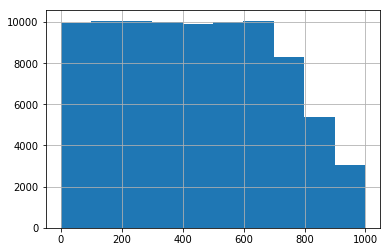

In [347]:
df_vectors['seq_len'].hist()

In [348]:
_t = df_vectors \
    .assign(bin=pd.cut(df_vectors['seq_len'], bins=np.arange(0, 1000, 100), right=True)) \
    .assign(acc=lambda x: x.predict == x.bins) \
    .groupby('bin')[['acc']].mean()
_t

,acc
bin,
"(0, 100]",0.468408
"(100, 200]",0.553988
"(200, 300]",0.586056
"(300, 400]",0.602163
"(400, 500]",0.603541
"(500, 600]",0.603909
"(600, 700]",0.602151
"(700, 800]",0.606983
"(800, 900]",0.608923


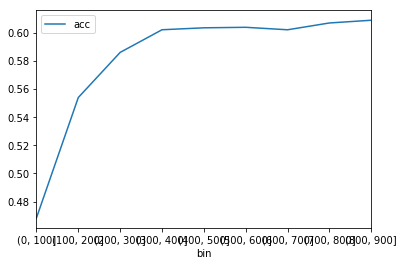

In [349]:
_t.plot()

In [350]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [351]:
pca = PCA(n_components=2)
pca.fit(df_vectors[embedding_columns].values)
np.sum(pca.explained_variance_ratio_)

0.3548493700493779

In [352]:
pca_results = pca.transform(df_vectors[embedding_columns].values)

In [353]:
df_pca = df_vectors.copy()
df_pca['_pca_x'] = pca_results[:, 0]
df_pca['_pca_y'] = pca_results[:, 1]

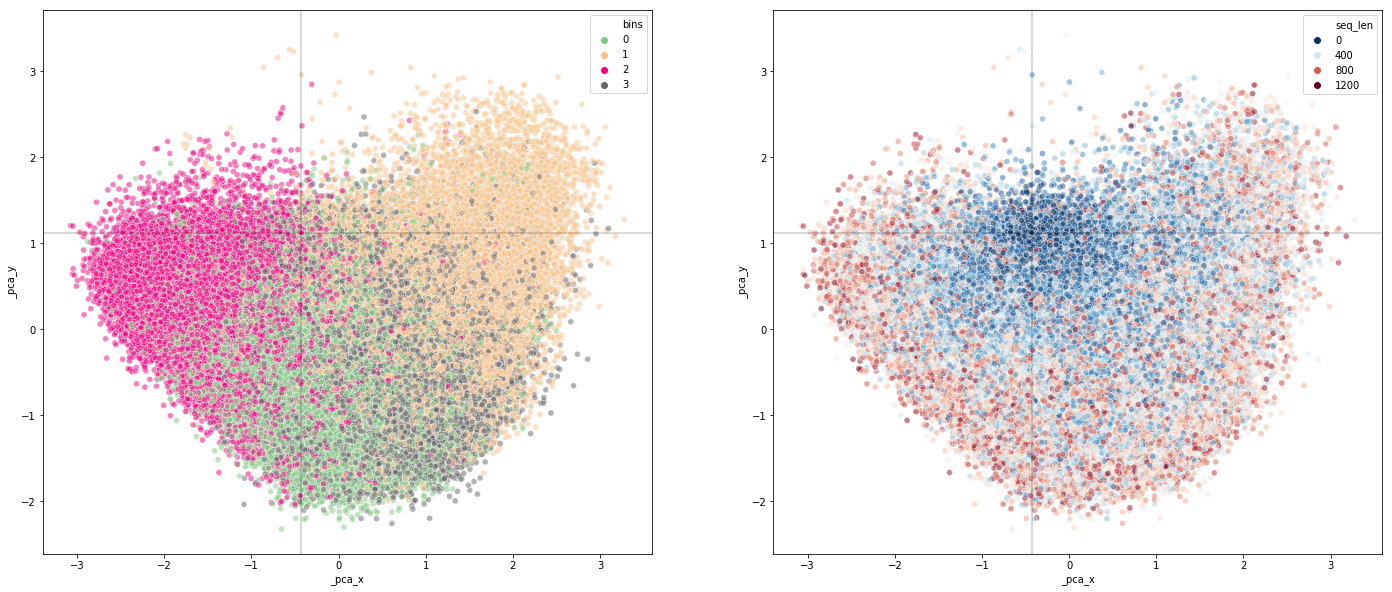

In [354]:
_, axs = plt.subplots(1, 2, figsize=(12 * 2, 10))

cmap = plt.get_cmap('tab10')

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue='bins',
    data=df_pca,
    palette='Accent',
    alpha=0.5,
    ax=axs[0],
)
axs[0].axvline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_x'].mean(), alpha=0.2, color='black')
axs[0].axhline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_y'].mean(), alpha=0.2, color='black')

for i in range(0):
    _t = df_pca[lambda x: x.client_id.eq(np.random.choice(df_pca.client_id.unique(), 1)[0])] \
        .sort_values(['seq_len', 'pos_s', 'pos_e'])
    axs[0].plot(_t['_pca_x'], _t['_pca_y'], color=cmap(i), linewidth=3)
    t = axs[0].text(_t.iloc[0]['_pca_x'], _t.iloc[0]['_pca_y'], str(int(_t.iloc[0]['seq_len'])))
    t.set_bbox({'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'white'})
    t = axs[0].text(_t.iloc[-1]['_pca_x'], _t.iloc[-1]['_pca_y'],
                    str(int(_t.iloc[-1]['seq_len'])) + ', ' + str(int(_t.iloc[-1]['bins'])))
    t.set_bbox({'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'white'})

sns.scatterplot(
    x='_pca_x', y='_pca_y',
    hue='seq_len',
    data=df_pca,
    palette='RdBu_r',
    alpha=0.5,
    ax=axs[1],
)
axs[1].axvline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_x'].mean(), alpha=0.2, color='black')
axs[1].axhline(df_pca[lambda x: x.seq_len == df_pca.seq_len.min()]['_pca_y'].mean(), alpha=0.2, color='black')

Относительный порядок категорий: 1 - 3 - 0 - 2

In [355]:
if len(df_pca) > 10000:
    df_tsne = df_pca.sample(n=10000).copy()
else:
    df_tsne = df_pca.copy()

In [356]:
tsne = TSNE(n_components=2, verbose=1, n_iter=300)
tsne_results = tsne.fit_transform(df_tsne[embedding_columns].values)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 20000 samples in 0.052s...
[t-SNE] Computed neighbors for 20000 samples in 55.944s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20000
[t-SNE] Computed conditional probabilities for sample 2000 / 20000
[t-SNE] Computed conditional probabilities for sample 3000 / 20000
[t-SNE] Computed conditional probabilities for sample 4000 / 20000
[t-SNE] Computed conditional probabilities for sample 5000 / 20000
[t-SNE] Computed conditional probabilities for sample 6000 / 20000
[t-SNE] Computed conditional probabilities for sample 7000 / 20000
[t-SNE] Computed conditional probabilities for sample 8000 / 20000
[t-SNE] Computed conditional probabilities for sample 9000 / 20000
[t-SNE] Computed conditional probabilities for sample 10000 / 20000
[t-SNE] Computed conditional probabilities for sample 11000 / 20000
[t-SNE] Computed conditional probabilities for sample 12000 / 20000
[t-SNE] Computed conditional probabilities for sa

In [357]:
df_tsne['_tsne_x'] = tsne_results[:, 0]
df_tsne['_tsne_y'] = tsne_results[:, 1]

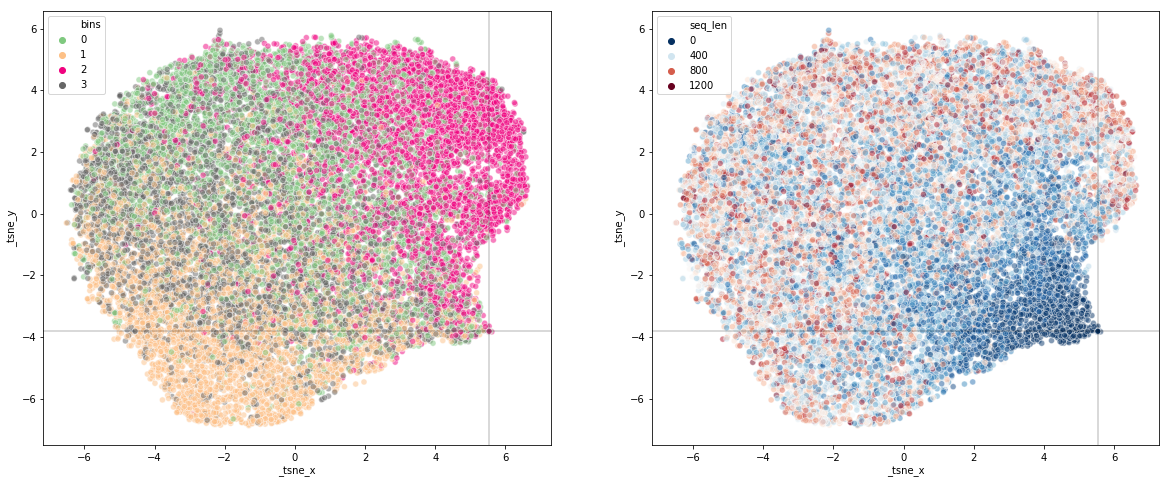

In [358]:
_, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.scatterplot(
    x='_tsne_x', y='_tsne_y',
    hue='bins',
    data=df_tsne,
    palette='Accent',
    alpha=0.5,
    ax=axs[0],
)
axs[0].axvline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_x'].mean(), alpha=0.2, color='black')
axs[0].axhline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_y'].mean(), alpha=0.2, color='black')

sns.scatterplot(
    x='_tsne_x', y='_tsne_y',
    hue='seq_len',
    data=df_tsne,
    palette='RdBu_r',
    alpha=0.5,
    ax=axs[1],
)
axs[1].axvline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_x'].mean(), alpha=0.2, color='black')
axs[1].axhline(df_tsne[lambda x: x.seq_len == df_tsne.seq_len.min()]['_tsne_y'].mean(), alpha=0.2, color='black')